In [2]:
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pre_df = pd.read_csv("pre_ai_df.csv")
post_df = pd.read_csv("post_ai_df.csv")
combined_df = pd.read_csv("merged_df_ai_status.csv")

In [4]:
## Pre AI Hypothesis test
# Separate groups based on daily_rating(neg and pos)
group_positive_pre = pre_df[pre_df['daily_rating'] == 1]['5d_return']
group_negative_pre = pre_df[pre_df['daily_rating'] == -1]['5d_return']
# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(group_positive_pre, group_negative_pre, equal_var =False)

if p_value < 0.05:
    print("There is a statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).")
else:
    print("There is no statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).")

There is a statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).


In [5]:
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -2.0670497332604136
P-value: 0.0412050025146761


In [6]:
## Post AI Hypothesis test
# Separate groups based on daily_rating
group_positive_post = post_df[post_df['daily_rating'] == 1]['5d_return']
group_negative_post = post_df[post_df['daily_rating'] == -1]['5d_return']

t_statistic, p_value = stats.ttest_ind(group_positive_post, group_negative_post, equal_var =False)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).")
else:
    print("There is no statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).")

T-statistic: 0.11229460979827996
P-value: 0.9110060752509432
There is no statistically significant difference between the means of the two groups (daily_rating 1 and daily_rating -1).


In [7]:
combined_df

,date,ticker,daily_rating,close,close_5d,5d_return,ai_status
0,2019-12-02,INTC,1.0,50.861420,49.864651,-0.019598,0
1,2019-12-03,GOOGL,1.0,64.251526,66.640984,0.037189,0
2,2019-12-03,META,1.0,197.440826,199.476578,0.010311,0
3,2019-12-04,AAPL,-1.0,63.152458,65.331223,0.034500,0
4,2019-12-04,META,-1.0,197.331558,200.856934,0.017865,0
...,...,...,...,...,...,...,...
2421,2025-09-08,NVDA,1.0,168.291138,177.740097,0.056147,1
2422,2025-09-09,AAPL,1.0,234.123047,237.919357,0.016215,1
2423,2025-09-10,AAPL,1.0,226.570358,238.758560,0.053794,1
2424,2025-09-11,NVDA,1.0,177.160141,176.230194,-0.005249,1


In [8]:
# Difference in Difference Pre vs Post

# Add post_ai interaction column (daily_rating*ai_status)
combined_df['post_ai_interaction'] = (combined_df['daily_rating'] * combined_df['ai_status']).astype(int)

# Columns
# Y (dependent variable): '5d_return' = 5 trading day forward return for 8 Stocks
# X1: 'daily_rating' = daily sentiment for the day where 1:net postive sentiment, 0:net negative sentiment
# X2: 'ai_status' = 1 if date > 2022-11-30
# X3: 'post_ai_interaction' = daily_rating * ai_status

# We want to test the change in daily_rating effect or the 'post_ai_interaction'

# Hypothesis test is essentially a T-Test on the interaction coefficient: 'post_ai_interaction'

# To test the Hypothesis we need to run a OLS regression

# H0: coef('post_ai_interaction') = 0

# If H0 rejected, analyst rating matters differently after AI
# If H0 not rejected, we cannot can neither confirm nor deny that analyst matters differently after AI

# run regression (sentiment x AI interaction)
X = combined_df[['daily_rating', 'ai_status', 'post_ai_interaction']]
y = combined_df['5d_return']

# Add a constant term to the independent variables
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              5d_return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.562
Date:                Wed, 14 Jan 2026   Prob (F-statistic):             0.0137
Time:                        03:45:38   Log-Likelihood:                 3203.6
No. Observations:                2426   AIC:                            -6399.
Df Residuals:                    2422   BIC:                            -6376.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0185    

In [9]:
ols_coeffs = model.params
ols_pvalues = model.pvalues
daily_rating_ols_coef = ols_coeffs['daily_rating']
daily_rating_ols_pvalue = ols_pvalues['daily_rating']
post_ai_ols_coef = ols_coeffs['ai_status']
post_ai_ols_pvalue = ols_pvalues['ai_status']
post_ai_interaction_ols_coef = ols_coeffs['post_ai_interaction']
post_ai_interaction_ols_pvalue = ols_pvalues['post_ai_interaction']
print(f"Daily Rating Coefficient: {daily_rating_ols_coef:.4f} (p-value: {daily_rating_ols_pvalue:.4f})")
print(f"Post AI Coefficient: {post_ai_ols_coef:.4f} (p-value: {post_ai_ols_pvalue:.4f})")
print(f"Post AI Interaction Coefficient: {post_ai_interaction_ols_coef:.4f} (p-value: {post_ai_interaction_ols_pvalue:.4f})")

Daily Rating Coefficient: -0.0109 (p-value: 0.0012)
Post AI Coefficient: -0.0110 (p-value: 0.0547)
Post AI Interaction Coefficient: 0.0116 (p-value: 0.0429)


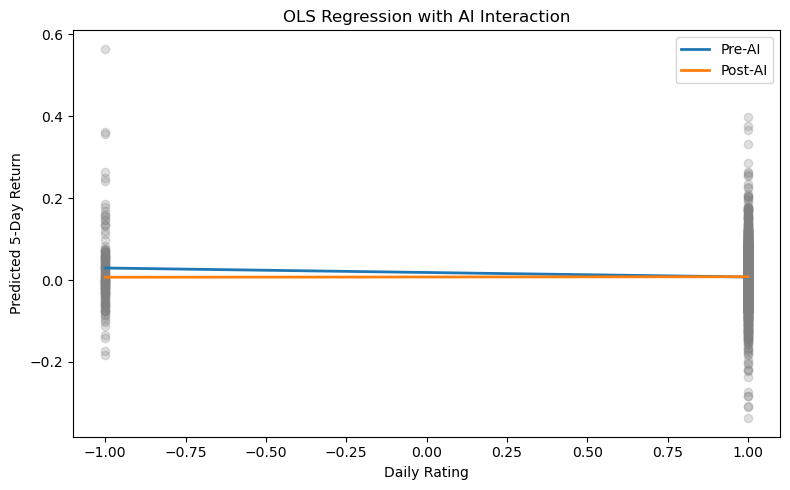

In [10]:
# Range of daily_rating
r = np.linspace(
    combined_df["daily_rating"].min(),
    combined_df["daily_rating"].max(),
    10
)

def predict_line(ai_value):
    X_pred = pd.DataFrame({
        "const": 1,
        "daily_rating": r,
        "ai_status": ai_value,
        "post_ai_interaction": r * ai_value
    })
    return model.predict(X_pred)

plt.figure(figsize=(8, 5))
plt.scatter(
    combined_df["daily_rating"],
    combined_df["5d_return"],
    alpha=0.25,
    color="gray"
)

plt.plot(r, predict_line(0), label="Pre-AI", linewidth=2)
plt.plot(r, predict_line(1), label="Post-AI", linewidth=2)

plt.xlabel("Daily Rating")
plt.ylabel("Predicted 5-Day Return")
plt.title("OLS Regression with AI Interaction")
plt.legend()
plt.tight_layout()
plt.show()


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


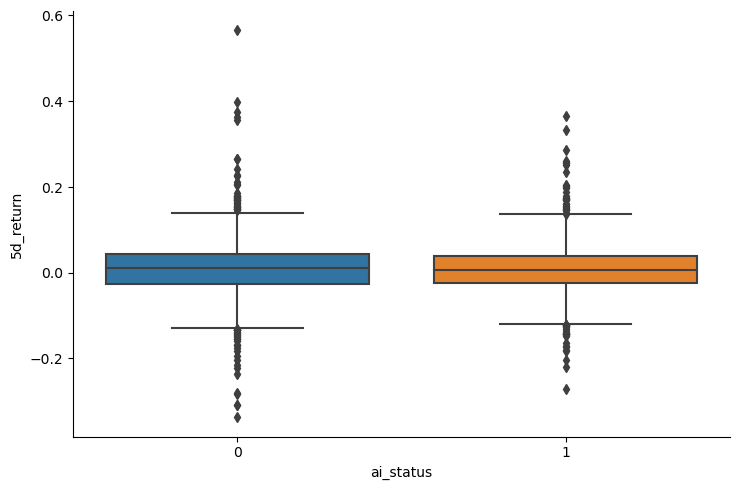

In [11]:
sns.catplot(data=combined_df, x="ai_status", y="5d_return", kind = "box", aspect = 1.5)


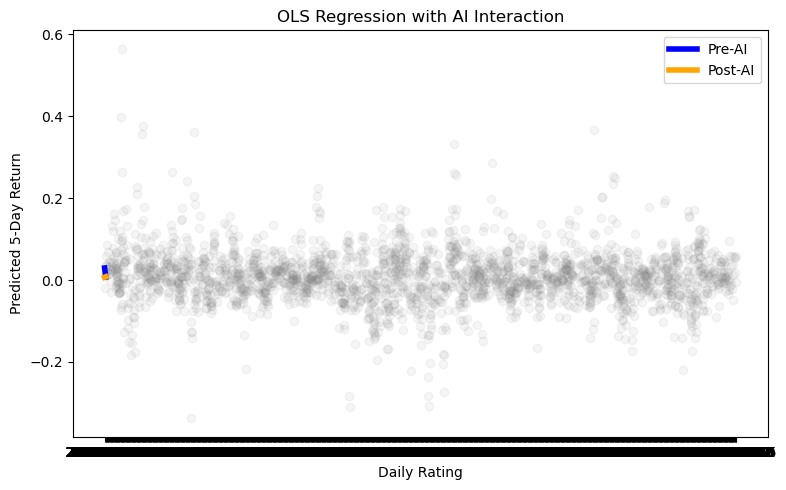

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

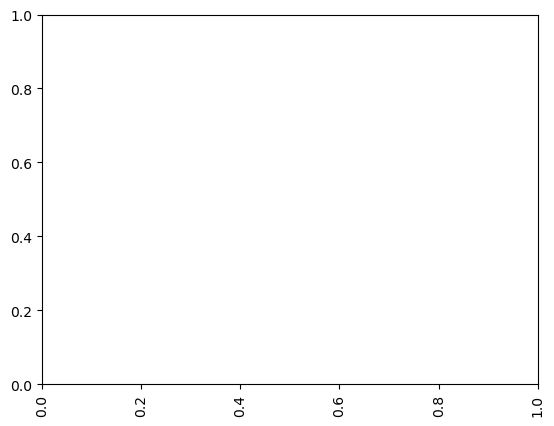

In [12]:
# Range of daily_rating
r = np.linspace(
    combined_df["daily_rating"].min(),
    combined_df["daily_rating"].max(),
    10
)

def predict_line(ai_value):
    X_pred = pd.DataFrame({
        "const": 1,
        "daily_rating": r,
        "ai_status": ai_value,
        "post_ai_interaction": r * ai_value
    })
    return model.predict(X_pred)

plt.figure(figsize=(8, 5))
plt.scatter(
    combined_df["date"],
    combined_df["5d_return"],
    alpha=0.08,
    color="gray"
)

plt.plot(r, predict_line(0), label="Pre-AI", color = "blue", linewidth=4)
plt.plot(r, predict_line(1), label="Post-AI", color = "orange", linewidth=4)

plt.xlabel("Daily Rating")
plt.ylabel("Predicted 5-Day Return")
plt.title("OLS Regression with AI Interaction")
plt.legend()
plt.tight_layout()
plt.show()
plt.xticks(rotation = 90)
